# Processing and Scaling

This is a rendered copy of [processing.ipynb](https://github.com/scikit-hep/coffea/blob/master/binder/processing.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fprocessing.ipynb)

Coffea relies mainly on [uproot](https://github.com/scikit-hep/uproot) to provide access to ROOT files for analysis.
As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. 

Since the beginning a `coffea.processor` module was provided to encapsulate the core functionality of the analysis, which could be run locally or distributed via a number of Executors. This allowed users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). This API ceased to exist for some time but we brought it back.

In coffa 202x (CalVer), you also have the option of deeper integration with `dask` (via `dask_awkward` and `uproot.dask`), and whether an analysis is to be executed on local or distributed resources, a TaskGraph encapsulating the analysis is created in this case. We will demonstrate how to use callable code to build these TGs.

We'll always be showcasing both ways of using coffea to write and execute your analyis

Let's start by writing a simple processor class that reads some CMS open data and plots a dimuon mass spectrum.
We'll start by copying the [ProcessorABC](https://coffea-hep.readthedocs.io/en/latest/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC) skeleton and filling in some details:

 * Remove `flag`, as we won't use it
 * Adding a new histogram for $m_{\mu \mu}$
 * Building a [Candidate](https://coffea-hep.readthedocs.io/en/latest/api/coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate.html#coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate) record for muons, since we will read it with `BaseSchema` interpretation (the files used here could be read with `NanoAODSchema` but we want to show how to build vector objects from other TTree formats) 
 * Calculating the dimuon invariant mass

## File access

In the examples below, we will be using local copies of the files for speed but I have also left the eospublic xrtood urls for them in comments

## Coffea Processors

In [1]:
import awkward as ak
import dask_awkward as dak
from coffea import processor
from coffea.nanoevents.methods import candidate
import hist
import hist.dask
import dask


class MyProcessor(processor.ProcessorABC):
    def __init__(self, mode="virtual"):
        assert mode in ["eager", "virtual", "dask"]
        self._mode = mode

    def process(self, events):
        dataset = events.metadata["dataset"]
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        if self._mode == "dask":
            hist_class = hist.dask.Hist
        else:
            hist_class = hist.Hist
        h_mass = hist_class.new.StrCat(["opposite", "same"], name="sign").Log(1000, 0.2, 200.0, name="mass", label=r"$m_{\mu\mu}$ [GeV]").Int64()

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="opposite", mass=dimuon.mass)

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) != 0)
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="same", mass=dimuon.mass)

        if self._mode == "dask":
            return {
                "entries": ak.num(events, axis=0),
                "mass": h_mass,
            }
        else:
            return {
                dataset: {
                    "entries": len(events),
                    "mass": h_mass,
                }
            }

    def postprocess(self, accumulator):
        pass

If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

 * Opens a CMS open data file
 * Creates a NanoEvents object using `BaseSchema` (roughly equivalent to the output of reading with plain `uproot`)
 * Creates a `MyProcessor` instance
 * Runs the `process()` function, which returns our accumulators

In [2]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import matplotlib.pyplot as plt

In [3]:
# filename = "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root"
filename = "/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/Run2012B_DoubleMuParked.root"
access_log = []
events = NanoEventsFactory.from_root(
    {filename: "Events"},
    entry_stop=500_000,
    metadata={"dataset": "DoubleMuon"},
    schemaclass=BaseSchema,
    mode="virtual",
    access_log=access_log,
).events()
p = MyProcessor("virtual")

In [4]:
%%time
out = p.process(events)
out

CPU times: user 178 ms, sys: 31.6 ms, total: 210 ms
Wall time: 280 ms


{'DoubleMuon': {'entries': 500000,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 245435.0 (245753.0 with flow)}}

In [5]:
set(access_log)

{'Muon_charge', 'Muon_eta', 'Muon_mass', 'Muon_phi', 'Muon_pt'}

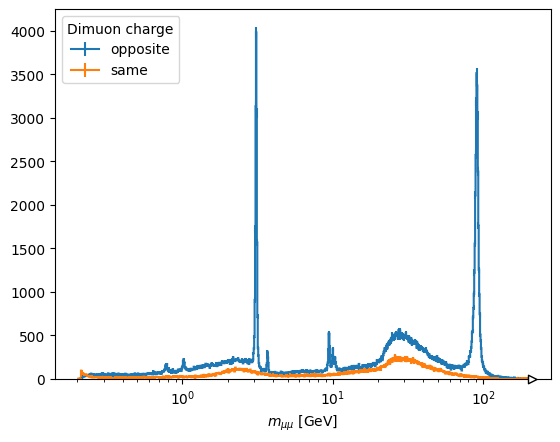

In [6]:
fig, ax = plt.subplots()
out["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")
plt.show()

In [7]:
# filename = "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root"
filename = "/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/Run2012B_DoubleMuParked.root"
events = NanoEventsFactory.from_root(
    {filename: {"object_path": "Events", "steps": [[0, 500_000]]}},
    metadata={"dataset": "DoubleMuon"},
    schemaclass=BaseSchema,
    mode="dask",
).events()
p = MyProcessor("dask")
taskgraph = p.process(events)
taskgraph

{'entries': dask.awkward<num, type=Scalar, dtype=int64, known_value=500000>,
 'mass': Hist(
   StrCategory(['opposite', 'same'], name='sign'),
   Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
   storage=Int64()) # (has staged fills)}

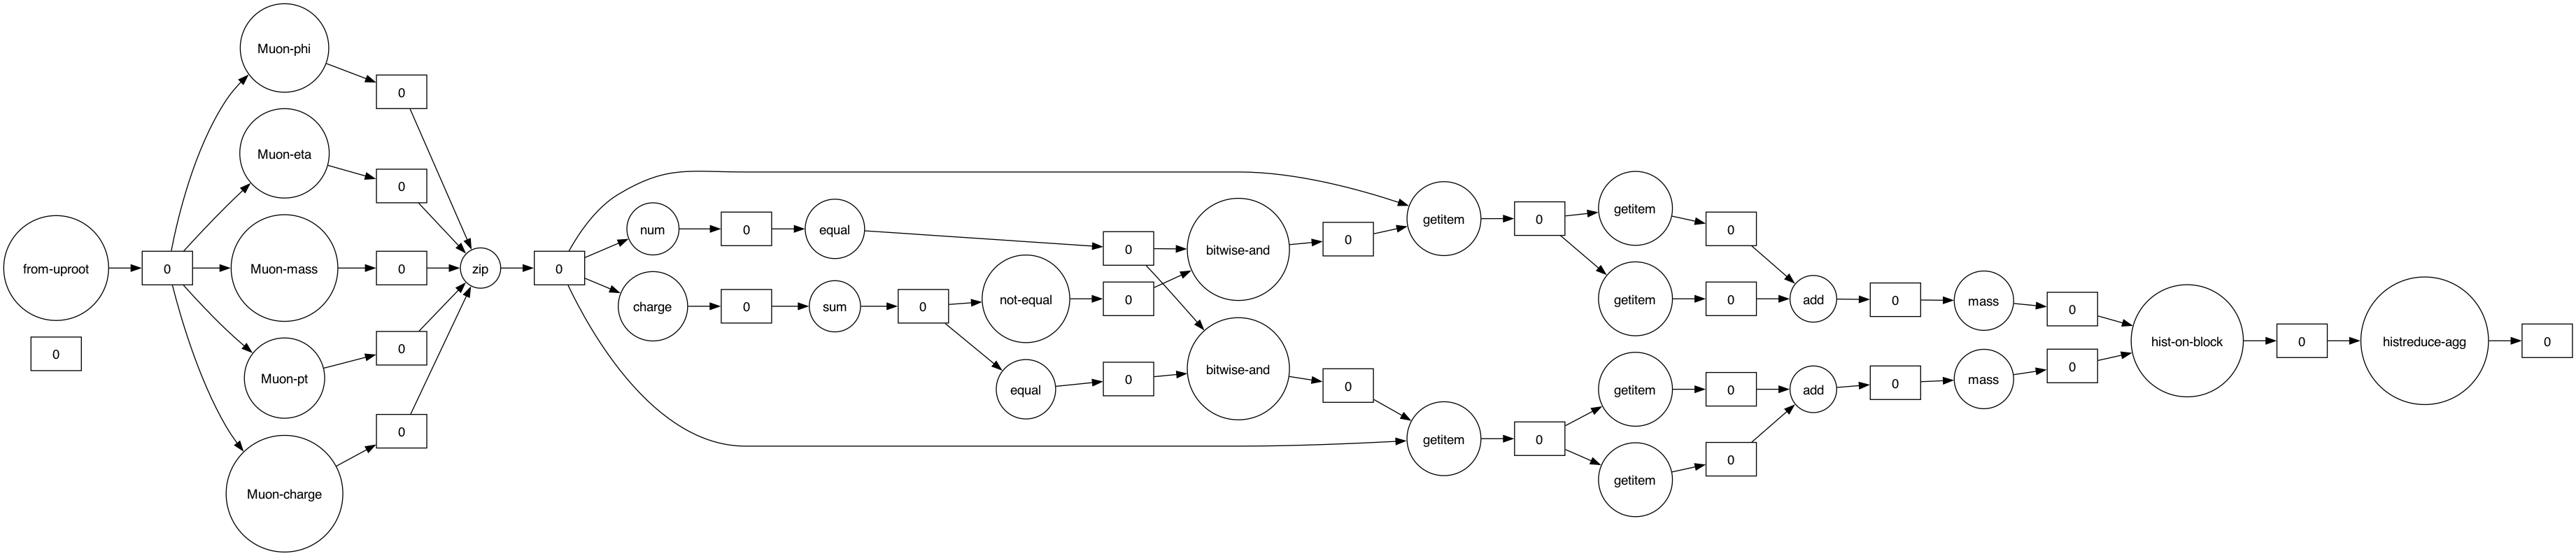

In [8]:
dask.visualize(taskgraph, rankdir="LR", optimize_graph=False)

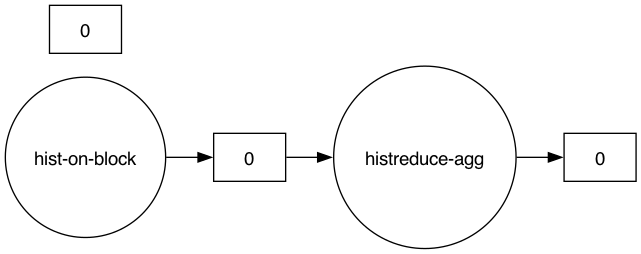

In [9]:
dask.visualize(taskgraph, rankdir="LR", optimize_graph=True)

In [10]:
%%time
(out,) = dask.compute(taskgraph)
out

CPU times: user 263 ms, sys: 38.9 ms, total: 302 ms
Wall time: 321 ms


{'entries': 500000,
 'mass': Hist(
   StrCategory(['opposite', 'same'], name='sign'),
   Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
   storage=Int64()) # Sum: 245435.0 (245753.0 with flow)}

In [11]:
dak.necessary_columns(taskgraph)

{'from-uproot-ece94f13a30832ab46c00668ff6af4a8': frozenset({'Muon_charge',
            'Muon_eta',
            'Muon_mass',
            'Muon_phi',
            'Muon_pt'})}

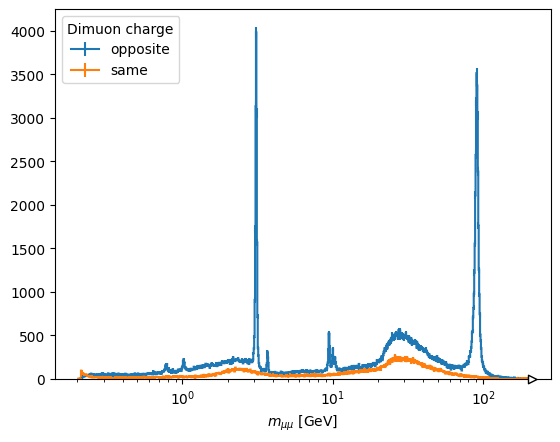

In [12]:
fig, ax = plt.subplots()
out["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")
plt.show()

## Filesets
We'll need to construct a fileset to run over

In [13]:
initial_fileset = {
    "DoubleMuon": {
        "files": {
            "/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/Run2012B_DoubleMuParked.root": "Events",
            # "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root": "Events",
        },
        "metadata": {
            "is_mc": False,
        },
    },
    "ZZ to 4mu": {
        "files": {
            "/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/ZZTo4mu.root": "Events",
            # "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo4mu.root": "Events",
        },
        "metadata": {
            "is_mc": True,
        },
    },
}

## Processing with Virtual mode

Preprocessing is hidden inside this interface

In [14]:
%%time
iterative_run = processor.Runner(
    executor=processor.IterativeExecutor(compression=None),
    schema=BaseSchema,
    maxchunks=3,
    savemetrics=True,
)

out, metrics = iterative_run(
    initial_fileset,
    processor_instance=MyProcessor("virtual"),
)

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [ 0:00:00 < 0:00:00 | 11.6 chunk/s ]

CPU times: user 439 ms, sys: 78.1 ms, total: 517 ms
Wall time: 569 ms


In [15]:
out

{'DoubleMuon': {'entries': 300090,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 146806.0 (147001.0 with flow)},
 'ZZ to 4mu': {'entries': 299814,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 57211.0 (57331.0 with flow)}}

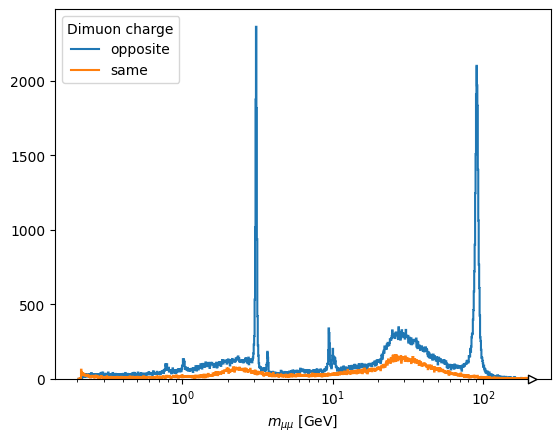

In [16]:
fig, ax = plt.subplots()
out["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")
plt.show()

Now, if we want to use more than a single core on our machine, we simply change `IterativeExecutor` for `FuturesExecutor`, which uses the python `concurrent.futures` standard library. We can then set the most interesting argument to the `FuturesExecutor`: the number of cores to use.

In [17]:
%%time
futures_run = processor.Runner(
    executor=processor.FuturesExecutor(workers=4, compression=None),
    schema=BaseSchema,
    savemetrics=True,
)

out, metrics = futures_run(initial_fileset, processor_instance=MyProcessor("virtual"))

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308/308 [ 0:00:07 < 0:00:00 | 48.6  chunk/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1/308 [ 0:00:07 < -:--:-- | ?    merges/s ]

CPU times: user 1.38 s, sys: 159 ms, total: 1.54 s
Wall time: 7.54 s


In [18]:
out

{'DoubleMuon': {'entries': 29308627,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 14378856.0 (14397111.0 with flow)},
 'ZZ to 4mu': {'entries': 1499064,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 288707.0 (289326.0 with flow)}}

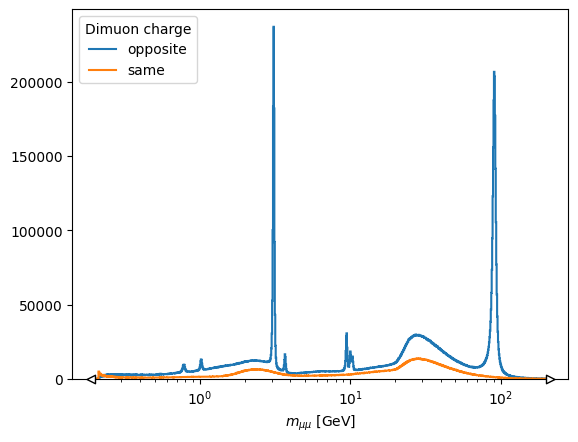

In [19]:
fig, ax = plt.subplots()
out["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")
plt.show()

In an analysis facility, all you need to do do scale your analysis, is connect to the facility's dask cluster

In [20]:
from dask.distributed import Client

# here we connect to the cluster of our analysis facility.
# if you are on coffea-casa for example, that should be something like
# client = Client("tls://localhost:8786")
# locally we can make our own cluster though
from dask.distributed import LocalCluster

cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 14
Total threads: 14,Total memory: 36.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56079,Workers: 14
Dashboard: http://127.0.0.1:8787/status,Total threads: 14
Started: Just now,Total memory: 36.00 GiB
Comm: tcp://127.0.0.1:56113,Total threads: 1
Dashboard: http://127.0.0.1:56114/status,Memory: 2.57 GiB
Nanny: tcp://127.0.0.1:56082,


In [21]:
%%time
dask_run = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
    chunksize=100_000,
    skipbadfiles=True,
    savemetrics=True,
)

out, metrics = dask_run(initial_fileset, processor_instance=MyProcessor("virtual"))

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326/326 [ 0:00:03 < 0:00:00 | 89.5 chunk/s ]

CPU times: user 740 ms, sys: 166 ms, total: 905 ms
Wall time: 3.84 s


In [22]:
out

{'DoubleMuon': {'entries': 29308627,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 14378856.0 (14397111.0 with flow)},
 'ZZ to 4mu': {'entries': 1499064,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 288707.0 (289326.0 with flow)}}

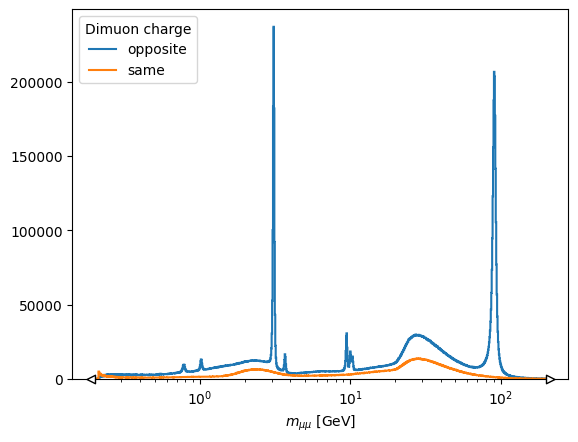

In [23]:
fig, ax = plt.subplots()
out["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")
plt.show()

## Processing with Dask mode

### Preprocessing
There are dataset discovery tools inside of coffea to help construct such datasets. Those will not be demonstrated here. For now, we'll take the above `initial_fileset` and preprocess it.

In [24]:
from coffea.dataset_tools import apply_to_fileset, max_chunks, max_files, preprocess

In [25]:
preprocessed_available, preprocessed_total = preprocess(
    initial_fileset,
    step_size=100_000,
    align_clusters=False,
    skip_bad_files=True,
    recalculate_steps=False,
    files_per_batch=1,
    file_exceptions=(OSError,),
    save_form=False,
    uproot_options={},
    step_size_safety_factor=0.5,
)

### Preprocessed fileset
Lets have a look at the contents of the preprocessed_available part of the fileset

In [26]:
preprocessed_available

{'DoubleMuon': {'files': {'/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/Run2012B_DoubleMuParked.root': {'object_path': 'Events',
    'steps': [[0, 100030],
     [100030, 200060],
     [200060, 300090],
     [300090, 400120],
     [400120, 500150],
     [500150, 600180],
     [600180, 700210],
     [700210, 800240],
     [800240, 900270],
     [900270, 1000300],
     [1000300, 1100330],
     [1100330, 1200360],
     [1200360, 1300390],
     [1300390, 1400420],
     [1400420, 1500450],
     [1500450, 1600480],
     [1600480, 1700510],
     [1700510, 1800540],
     [1800540, 1900570],
     [1900570, 2000600],
     [2000600, 2100630],
     [2100630, 2200660],
     [2200660, 2300690],
     [2300690, 2400720],
     [2400720, 2500750],
     [2500750, 2600780],
     [2600780, 2700810],
     [2700810, 2800840],
     [2800840, 2900870],
     [2900870, 3000900],
     [3000900, 3100930],
     [3100930, 3200960],
     [3200960, 3300990],
     [3300990, 3401020],
     [3401020, 3501050],
 

### Saving a preprocessed fileset
We can use the gzip, pickle, and json modules/libraries to both save and reload datasets directly. We'll do this short example below

In [27]:
import gzip
import json

output_file = "example_fileset"
with gzip.open(f"{output_file}_available.json.gz", "wt") as file:
    json.dump(preprocessed_available, file, indent=2)
    print(f"Saved available fileset chunks to {output_file}_available.json.gz")
with gzip.open(f"{output_file}_all.json.gz", "wt") as file:
    json.dump(preprocessed_total, file, indent=2)
    print(f"Saved complete fileset chunks to {output_file}_all.json.gz")

Saved available fileset chunks to example_fileset_available.json.gz
Saved complete fileset chunks to example_fileset_all.json.gz


We could then reload these filesets and quickly pick up where we left off. Often we'll want to preprocess again "soon" before analyzing data because this will let us catch which files are accessible now and which are not. The saved filesets may be useful for tracking, and we may have enough stability to reuse it for some period of time.

In [28]:
with gzip.open(f"{output_file}_available.json.gz", "rt") as file:
    reloaded_available = json.load(file)
with gzip.open(f"{output_file}_all.json.gz", "rt") as file:
    reloaded_all = json.load(file)

### Slicing chunks and files
Given this preprocessed fileset, we can test our processor on just a few chunks of a handful of files. To do this, we use the max_files and max_chunks functions from the dataset tools

In [29]:
test_preprocessed_files = max_files(preprocessed_available, 1)
test_preprocessed = max_chunks(test_preprocessed_files, 3)

In [30]:
test_preprocessed

{'DoubleMuon': {'files': {'/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/Run2012B_DoubleMuParked.root': {'object_path': 'Events',
    'steps': [[0, 100030], [100030, 200060], [200060, 300090]],
    'num_entries': 29308627,
    'uuid': '7a4da368-cfd1-11e8-9717-97650d81beef'}},
  'metadata': {'is_mc': False},
  'form': None},
 'ZZ to 4mu': {'files': {'/Users/iason/work/pyhep_dev/uscms-idap-training/coffea/ZZTo4mu.root': {'object_path': 'Events',
    'steps': [[0, 99938], [99938, 199876], [199876, 299814]],
    'num_entries': 1499064,
    'uuid': '9fb6f85c-cfd1-11e8-9717-97650d81beef'}},
  'metadata': {'is_mc': True},
  'form': None}}

In [31]:
small_tg, small_rep = apply_to_fileset(
    data_manipulation=MyProcessor("dask"),
    fileset=test_preprocessed,
    schemaclass=BaseSchema,
    uproot_options={"allow_read_errors_with_report": (OSError, ValueError)},
)

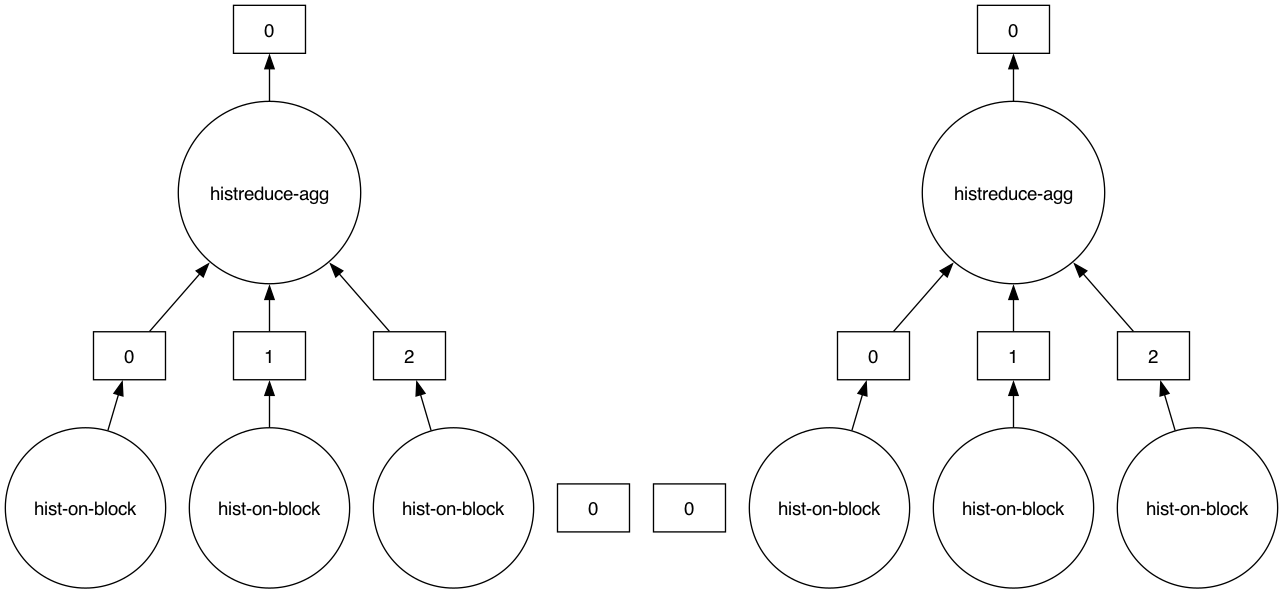

In [32]:
dask.visualize(small_tg, optimize_graph=True)

In [33]:
%%time
small_computed, small_rep_computed = dask.compute(small_tg, small_rep)

CPU times: user 121 ms, sys: 14.5 ms, total: 135 ms
Wall time: 241 ms


In [34]:
small_rep_computed["DoubleMuon"]

<Array [{call_time: None, ...}, ..., {...}] type='3 * {call_time: ?unknown,...'>

In [35]:
small_computed

{'DoubleMuon': {'entries': 300090,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 146806.0 (147001.0 with flow)},
 'ZZ to 4mu': {'entries': 299814,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 57211.0 (57331.0 with flow)}}

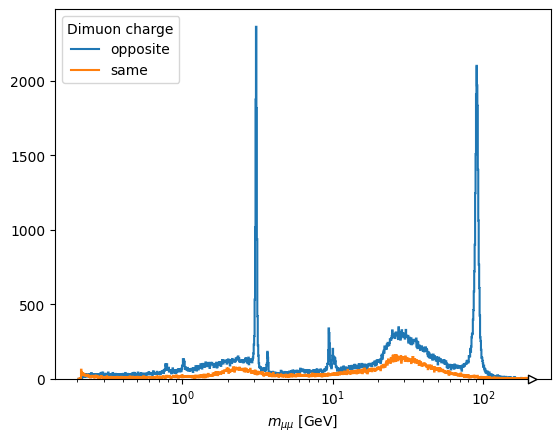

In [36]:
fig, ax = plt.subplots()
small_computed["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")
plt.show()

In [37]:
full_tg, rep = apply_to_fileset(
    data_manipulation=MyProcessor("dask"),
    fileset=preprocessed_available,
    schemaclass=BaseSchema,
    uproot_options={"allow_read_errors_with_report": (OSError, ValueError)},
)

Dask automatically uses a client if there is one alive to compute. If you haven't destroyed the `client/cluster` above, this computation will use it. Look at the dask docs about how to configure computation.

In [38]:
%%time
out, rep = dask.compute(full_tg, rep)

CPU times: user 2 s, sys: 152 ms, total: 2.15 s
Wall time: 3.08 s


In [39]:
out

{'DoubleMuon': {'entries': 29308627,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 14378856.0 (14397111.0 with flow)},
 'ZZ to 4mu': {'entries': 1499064,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 288707.0 (289326.0 with flow)}}

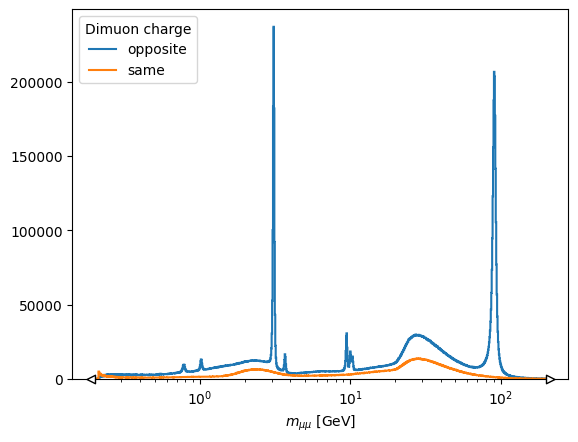

In [40]:
fig, ax = plt.subplots()
out["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")
plt.show()